In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dtaidistance import dtw

In [2]:
# Construindo a classe do detector de drift (conforme implementado anteriormente)
class EmpiricalDTWDriftDetector:
    def __init__(self, fixed_window: np.ndarray, sliding_size: int, n_subsamples: int = 30):
        self.fixed_window = fixed_window
        self.sliding_size = sliding_size
        self.n_subsamples = n_subsamples
        self.distances = []
        self.mean = None
        self.std = None
        self._build_empirical_distribution()

    def _build_empirical_distribution(self):
        max_start = len(self.fixed_window) - self.sliding_size
        
        samples = []
        for _ in range(self.n_subsamples):
            start = np.random.randint(0, max_start)
            subwindow = self.fixed_window[start:start + self.sliding_size]
            dist = dtw.distance(self.fixed_window, subwindow)
            samples.append(dist)

        self.distances = np.array(samples)
        self.mean = np.min(self.distances)
        self.std = np.std(self.distances)

    def test_window(self, sliding_window: np.ndarray):
        dist = dtw.distance(self.fixed_window, sliding_window)
        if dist > self.mean + 2 * self.std:
            status = 'alarm'
        elif dist > self.mean + self.std:
            status = 'warning'
        else:
            status = 'normal'
        return dist, status

    def get_empirical_info(self):
        return {'mean': self.mean, 'std': self.std, 'distances': self.distances}

In [3]:
# Função para carregar a série do arquivo CSV
def load_series(file_path):
    # Ignora as duas primeiras linhas e lê os dados
    df = pd.read_csv(file_path, skiprows=2, names=["Date", "Close"])

    # Remove valores NaN e retorna como array
    return df["Close"].dropna().values.reshape(-1, 1)

In [4]:
# Carregando a série temporal do arquivo
file_path = '../series/GSPC.csv'  # Ajuste o caminho para onde o seu arquivo está localizado
original_series = load_series(file_path)[:600]

In [5]:
# Definindo a janela fixa e o tamanho da janela deslizante
batch_size = 100
fixed_window = original_series[:batch_size]
sliding_size = int(batch_size/2)  # Tamanho da janela deslizante

In [6]:
# Criando o detector
detector = EmpiricalDTWDriftDetector(fixed_window=original_series, sliding_size=sliding_size)

In [7]:
distances = [None] * batch_size
statuses = []
positions = []

In [8]:
for i in range(batch_size, len(original_series) - sliding_size + 1):  # ajustado para incluir o último bloco
    window = original_series[i:i + sliding_size]
    dist, status = detector.test_window(window)
    distances.append(dist)
    statuses.append(status)
    positions.append(i + sliding_size - 1)  # pegamos o último índice da janela deslizante

In [9]:
# Transformar em array para facilitar os filtros
distances_array = np.array(distances)
statuses_array = np.array([None]*batch_size + statuses)
positions_array = np.array([None]*batch_size + positions)

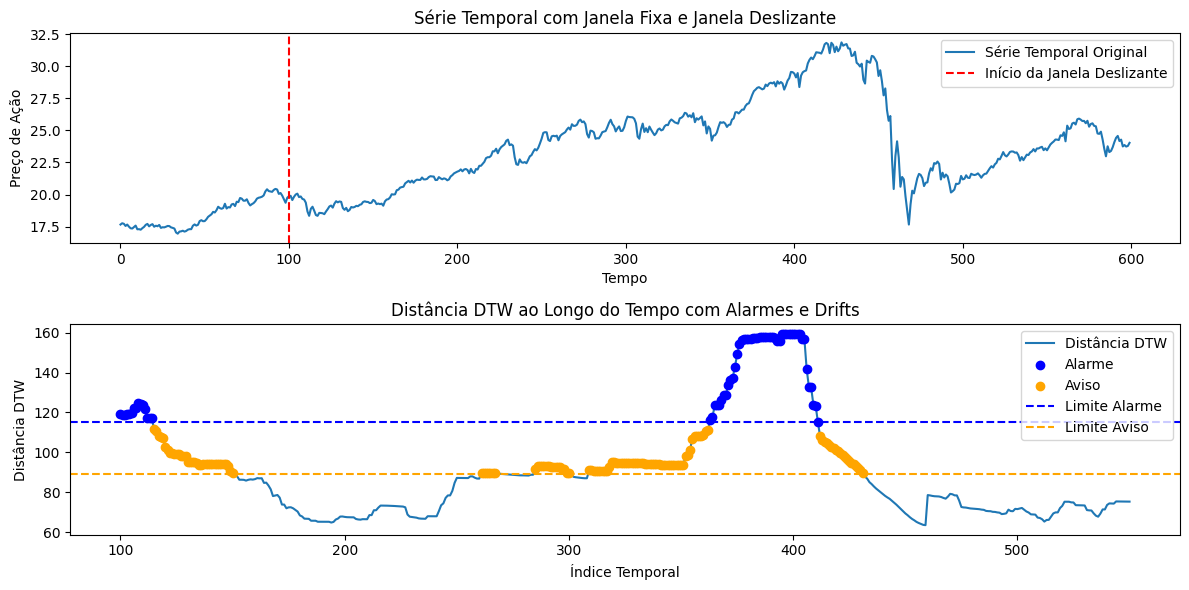

In [10]:
# Plot
plt.figure(figsize=(12, 6))

# Série temporal
ax1 = plt.subplot(2, 1, 1)
ax1.plot(original_series, label='Série Temporal Original')
ax1.axvline(x=batch_size, color='red', linestyle='--', label='Início da Janela Deslizante')
ax1.title.set_text('Série Temporal com Janela Fixa e Janela Deslizante')
ax1.set_xlabel('Tempo')
ax1.set_ylabel('Preço de Ação')
ax1.legend()

# Distância DTW
ax2 = plt.subplot(2, 1, 2)
ax2.plot(distances, label='Distância DTW')
# Plotar alarmes e avisos nos lugares certos
alarm_idx = [idx for idx, status in enumerate(statuses_array) if status == 'alarm']
warning_idx = [idx for idx, status in enumerate(statuses_array) if status == 'warning']

ax2.scatter(alarm_idx, distances_array[alarm_idx], color='blue', label='Alarme', zorder=5)
ax2.scatter(warning_idx, distances_array[warning_idx], color='orange', label='Aviso', zorder=5)
ax2.axhline(detector.mean + 2 * detector.std, color='blue', linestyle='--', label='Limite Alarme')
ax2.axhline(detector.mean + detector.std, color='orange', linestyle='--', label='Limite Aviso')
ax2.title.set_text('Distância DTW ao Longo do Tempo com Alarmes e Drifts')
ax2.set_xlabel('Índice Temporal')
ax2.set_ylabel('Distância DTW')
ax2.legend()

plt.tight_layout()
plt.show()